The goal of this project was to identify curved lane markings from hood- or dash-mounted camera view. Broadly, the complete pipeline used three steps:
1. Correct for barrel distortion and use a four-point perspective transformation to produce a top-down view.
2. Use a combination of thresholding, image derivatives, and other OpenCV effects to extract only the pixels associated with the two lane markings.
3. Produce polynomial fit lines to the found pixels, both in image space, and in world space. Use the latter to estimate the radius of curvature of the lane, and the car's deviation from center (in meters).

In [1]:
import numpy as np, matplotlib.pyplot as plt, cv2
import cvflow as cf
import laneFindingPipeline
from utils import ShowOpClip
from jupyterTools import src, propertySrc

allFrames = laneFindingPipeline.utils.loadFrames()
showOpClip = ShowOpClip(allFrames['harder_challenge'][:32])
frame = allFrames['project'][-1]

%matplotlib inline

# Preprocessing pipeline

## `cvflow` for visualizing OpenCV pipelines
I fell down a rabbithole on this project implementing a computational graph library for assembling my OpenCV pipelines. This was inspired (obviously) by TensorFlow. Though here I use such an approach merely for convenience of introspection rather than for allowing for code generation, I could see that being an alternate use. Towards the end of this report, I'll list this and a few other possible future improvements to this library.

The basic object in cvflow is the `Op` (aka "node"), which wraps some operation, such as a simple `Add` of two or more arrays, or more relevantly, something like `cv2.cvtColor`. Crucially, `Op` objects contain a `parents` list, which they use directly in their wrapped operation, a `object.value` property which returns the result of this operation, and a `children` list, each of whom have this object as a parent and make use of its `object.value` property.

These nodes form a directed acyclic graph (DAG) (though I do no explict test for acyclicity, I rely on it throughout to avoid `RecursionError`s), so the `object.value` properties are cached on their first evaluation so that they are not recomputed for use by multiple children. A special `Op` subclass called `BaseImage` (with subclasses `ColorImage` and `MonoImage` acting as further offenses in the ongoing violation of [YAGNI](https://en.wikipedia.org/wiki/You_aren%27t_gonna_need_it) that is this library) calls `self.invalidateCache` on the setter of the `self.value` property, which recursively calls itself on the children of the `BaseImage`. 

In [4]:
laneFindingPipeline.ConvolutionalMarkingFinder.update?

In [3]:
laneFindingPipeline.MarginSearchMarkingFinder.update?

In [2]:
op = cf.Op()
src(op.invalidateCache)

Thus, with one such node serving as the primary user-interactive root node for the digraph, setting its `.value` results in clearing the cached values for all descendants. I have not implemented this cache-clearing cascade behavior for any other types of root nodes (e.g., `Constant` nodes such as kernel matrices), since I figured I had to draw the line somewhere on this project. I also have not tested this approach with pipelines containing multiple `BaseImage` input nodes, but the behavior should work for those as well--only nodes which are direct descendants of the currently altered node will have their cache cleared, which is as it should be. Clearing the cache for a node twice is harmless.

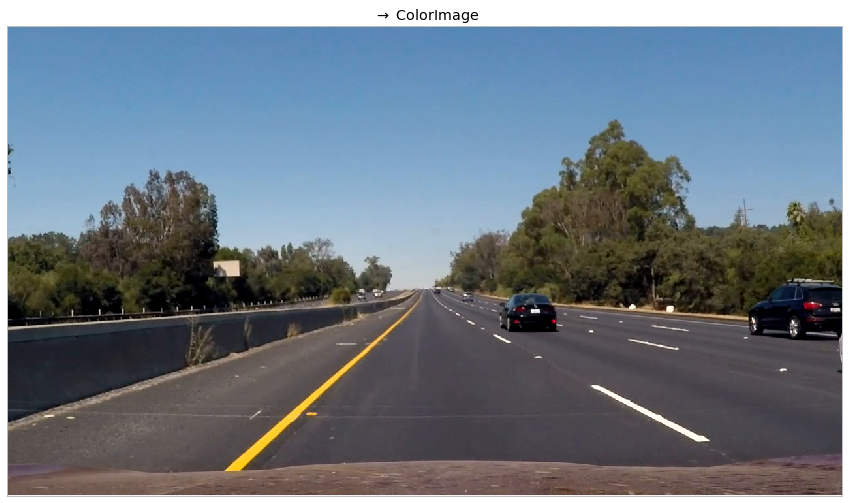

In [3]:
colorImage = cf.ColorImage()
colorImage.value = frame
colorImage.showValue();

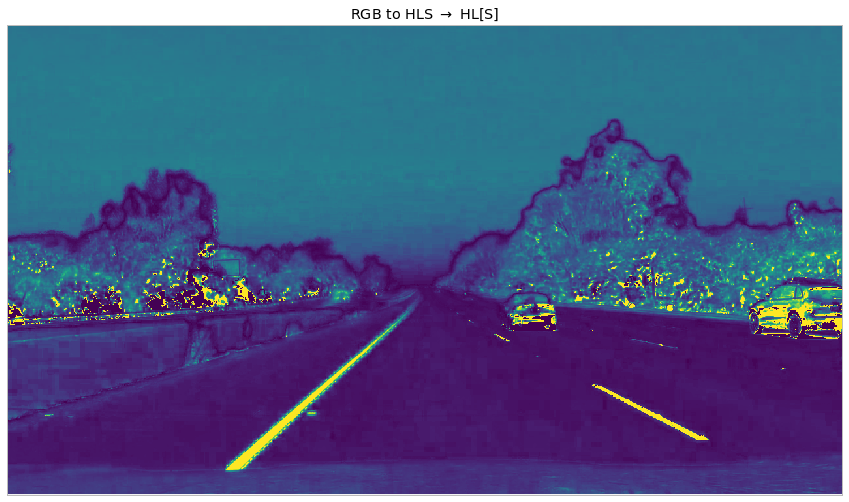

In [4]:
hls = cf.CvtColor(colorImage, cv2.COLOR_RGB2HLS)
s = cf.ColorSplit(hls, 2)
s.showValue();

Some operator overloading is also implemented.

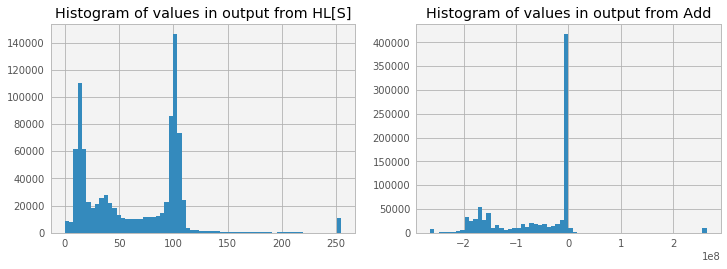

In [5]:
# Re-implement the `cf.Expand` op,
# for emphasizing outliers in a nonlinear way.
x = cf.AsType(s, 'float64')
centered = x - x.max() / 2
neg = centered < 0
pos = centered >= 0
widenedFlippedSign = centered ** 4
expanded = -abs(widenedFlippedSign & neg) + (widenedFlippedSign & pos)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, x in enumerate([s, expanded]):
    img = x.value

    ax = axes[i]
    ax.hist(img.ravel(), bins=64);
    ax.set_title('Histogram of values in output from %s' % x)

A second useful effect of this DAG structure is that requesting `object.value` on some leaf node propagates the execution of wrapped operations only up through direct ancestor nodes, without wastefully computing the results of side branches. This allows for the addition of speculative chains of operations that do not lead to the final result, for exploration purposes without slowing down the main execution, though there would be no reason to keep these in production. Analogously to the use of preprocessor directives in compiled languages, full-DAG operations take place only at instantiation time (and for some plotting and introspection purposes not necessary for executing the graph), not at execution.

Subclassing `Op` is the `MultistepOp` class, which adds additional logic supporting nodes that wrap subgraphs of other nodes in convenient bundles. This became a primary motivation for the (perhaps inadvisable) creation of this library when I noticed that certain motifs of repeated OpenCV operations were useful in my pipeline. 

Of course, such reused multi-step operations in OpenCV could be accomplished just fine through normal functions, but it would be difficult to introspect their structure and intermediate stages. This was the other major motivation for this library. Upon request, any node in the digraph can assemble an object representing the entire digraph in a convenient form (a combination of networkx and graphviz digraph objects). Courtesy of graphviz, this representation can be displayed in a Jupyter notebook, or written to various file formats.

We'll now use this to depict the DAG we've just constructed.

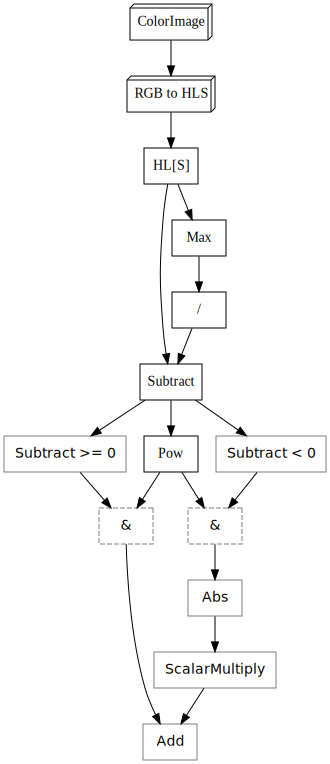

In [6]:
expanded.draw(addKey=False)

The key used for these diagrams is always as follows:

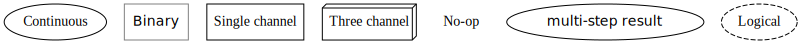

In [7]:
label, gv, nx = cf.misc.makeKeySubgraph()
gv

## A simple pipeline

With significant effort invested to create this library, we can now use it to prototype some image pre-processing pipelines.

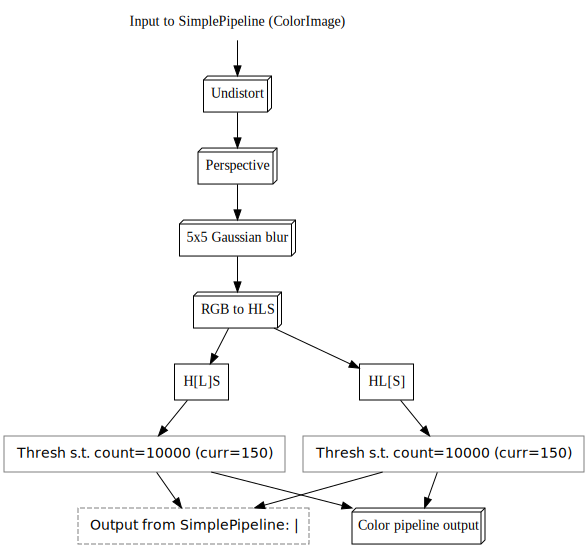

In [8]:
pipeline = cf.SimplePipeline()
pipeline.getSubgraph()

This pipeline is fairly simple--we use the saturation channel to detect the yellow left line, and the lightness channel to detect the white right line. It works for most of the project video.

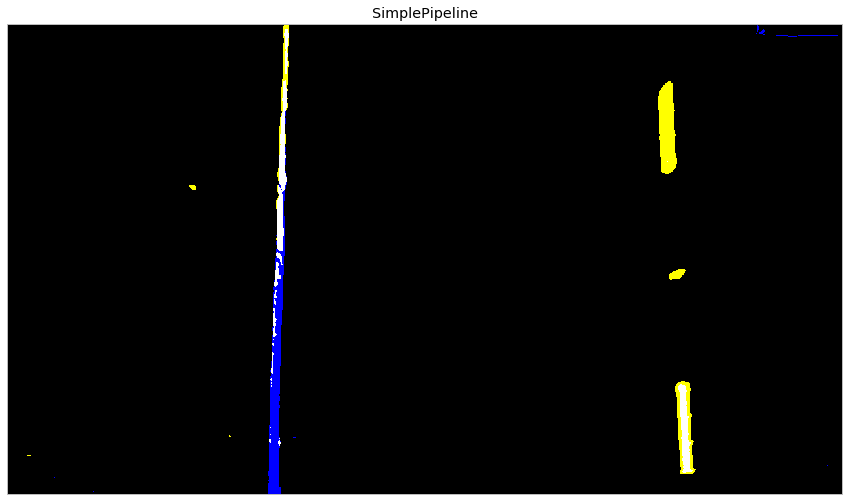

In [9]:
linePixels = pipeline(frame)
color = pipeline.colorOutput.value
laneFindingPipeline.utils.show(color, title=pipeline);

the pipeline begins with correcting camera distortion and performing a perspective transform.

Brieftly, the undistortion attemps to uses `cv2.findChessboardCorners` to find a set of image points corresponding to known-planar object points for each of the supplied camera calibration images.


In [10]:
src(cf.workers.UndistortTransformer.fitImg)

It then finds the camera parameters that best correct all of these distorted image points ot world points.

In [11]:
src(cf.workers.UndistortTransformer.calcParams)

This is implemented both in the worker class `UndistortTransformer` and in the node `Undistort`.

Likewise, a perspective transformation worker class uses `cv2.getPerspectiveTransform` during construction to find both forward and inverse transformation matrices, and `cv2.warpPerspective` to apply one or the other of these at call time.

In [12]:
src(cf.workers.PerspectiveTransformer.__call__)

To find only relevant pixels in each channel, I use the complicated (but not `MultistepOp`) `CountSeekingThreshold` op.

In [13]:
thresh = pipeline.getByKind(cf.CountSeekingThreshold)[0]
propertySrc(thresh, 'value')

Basically, we set a `goalCount` of around 10000 pixels, then, rely on the fact that the number of thresholded pixels is monotonic in the current threshold to do a bifurcation search for the threshold that brings us within `countTol` of the goal.

It occurs to me that such a dynamic thresholding might already be implemented in OpenCV, but, since other Sobel-only methods actually proved more useful than thresholding of any kind, I didn't pursue this further.

The problem with this or a fixed-threshold approach is that occasionally large splotches of brightness would come along in the monitored channel. For any reasonable `goalCount`, these splotches would quickly drive the threshold up to the maximum of 255, resulting in a mask empty of identified pixels.

## A more complicated pipeline

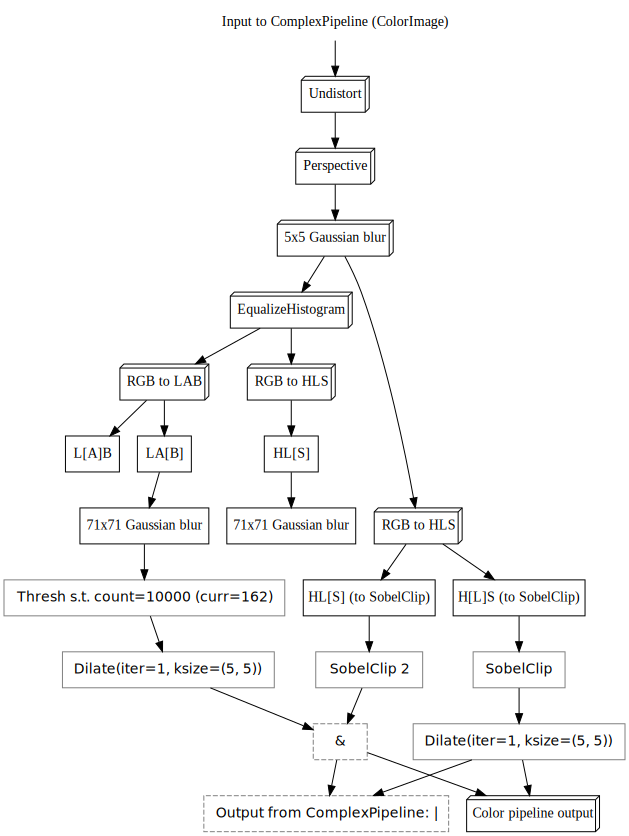

In [14]:
pipeline = cf.ComplexPipeline()
# Initialize the input.
pipeline(allFrames['harder_challenge'][-1]);
pipeline.getSubgraph()

Though this pipeline was not used, it has a couple notable features. First, there are two leaf nodes--L[A]B and a blurred HL[S}--which do not contribute to the final output. These are included in some vlsualizations, but not computed for the purposes of finding actual lane markings.

### The `SobelClip` `MultiOp`

Second, in addition to the `EqualizeHistogram` operation, which internally uses `cv2.equalizeHist`, there is a previously unseen operation called `SobelClip`. This is a subclass of `MultistepOp`.

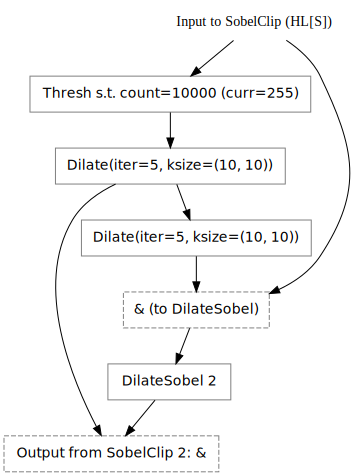

In [15]:
aSobelClip = pipeline.getByKind(cf.SobelClip)[0]
aSobelClip.getSubgraph()

This operation works by first using our previously-discussed `CountSeekingThreshold` to detail an initial set of interesting pixels. This set is then slightly dilated to produce a restrictive mask for use in the final `&`, and dilated more to produce a permissive mask on the original data. this prevents the subsequent application of a `DilateSobel` operation (discussed below) from activating on irrelevant features (per one definition). Finally, the lesser dilation is used as a mask, alowing us to be relatively liberal with what we allow the wider mask to present to the `DilateSobel` for consideration.

(Note that outputs from `showOpClip` like the following, though static in PDF renderings of this notebook, are animated in the notebook visible on Github.)

In [16]:
showOpClip(aSobelClip)

While this might sometimes produce some useful results, as in the example above, its reliance on on a threshold makes it vulnerable to large splotches of brightness or darkness in the observed channel. My later work made me question what value these dilated-threshold masks were adding to the underlying Sobel-based method.

### The Dilate Sobel `MultistepOp`
On the other hand, one composite operation that I did find repeatedly useful was a combination of multiple asymmetric Sobel operations.

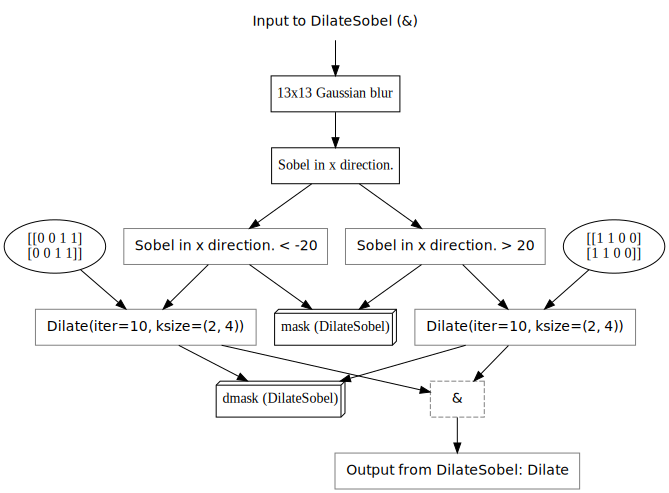

In [17]:
aDilateSobel = pipeline.getByKind(cf.DilateSobel)[0]
# show ndarray kernels explicitly
for dilate in aDilateSobel.getMembersByType(cf.Dilate):
    for parent in dilate.parents:
        if isinstance(parent, cf.Constant):
            # Show the kernels in the diagram, but not in the preview clip.
            parent.hidden = parent.isVisualized = False
            if isinstance(parent.value, np.ndarray):
                parent.nodeName = '%s' % parent.value
aDilateSobel.getSubgraph()

Note that, here, I've unhidden two constant dilation kernels.

Sobel in the x direction returns a continuous-valued array of positive and negative values, indicating locations where the x-derivative of the image is positive or negative, respectively. By using two thresholds, we separately extract these two rising- and falling-edge signals. Since lane lines are generally always a fixed number of pixels wide in our images, **we generally want only vertical rising edges that are quickly followed by falling edges** (for "ridges"; this is reversed for "troughs", which is how lane lines might manifest in some channels).

We can extract only such edge combinations by differentially dilating the our two thresholded sobel signals. Since dilation can be thought of as pulling a pixel value from neighbors indicated by nonzero locations in the centered kernel, the two constant kernels shown in the diagram above have the effect of dilating these found pixels exclusively to one side or the other. When rising edges are dilated to the right, and falling to the left, This filter discovers vertical ridges of a particular width. This is visible in the color composite images below, which show the two masks before and after this dilation, as well as the intersection that appears.

In this particular example, the input to the `DilateSobel` comes from an enclosing `SobelClip` operation, so the true edge is enclosed in a wide-masked bounding tube. While the initial Sobel convolution of the `DilateSobel` picks up these outer edges as well, the intersection of the differentially dilated positive and negative thresholds correctly excludes these outer edges as being part of a structure of the incorrect width.

In the next pipeline, I do use `DilateSobel` directly without `SobelClip`, and so this outer bounding tube does not take effect.

In [18]:
showOpClip(aDilateSobel)

/mnt/wdblue/Dropbox/Projects/Lane Lines/cvflow/misc.py:400: UserWarning: Using a non-unity scaling for float image data. This might cause flashing in output.
  warn('Using a non-unity scaling for float image data. This might cause flashing in output.')


## Full pipeline

Using methods from these last two pipelines, I set out to design a preprocessing pipeline in a more principled way. Namely, My strategy was to produce several pixel-finders focused on identifying a particular line in a "permissive" way (that is, they err on the side of finding too many pixels) and then take the intersection (`&`) of these masks to produce a "restrictive" mask focused on that feature. I did this separately for the left (yellow solid) and right (white dashed) lane markings.

Finally, I took the union (`|`) of these restrictive masks to produce the final output of the preprocessing pipeline.

In the diagram below, I style some nodes focused on discovering these left and right markings with red and blue annotations, respectively (it is possible for some nodes to be used for both). Broadly speaking, I use color features for finding the yellow marking, and brightness features to find the white marking.

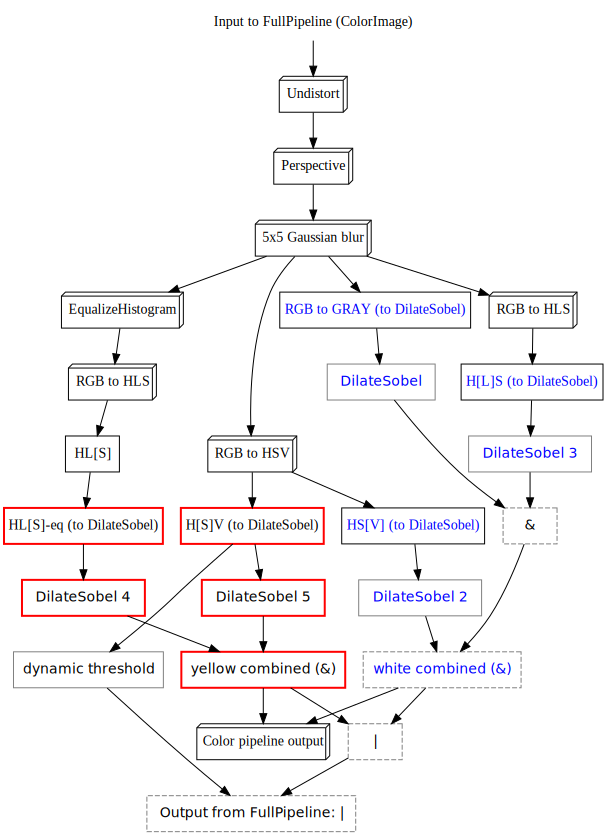

In [19]:
pipeline = cf.FullPipeline()
pipeline.getSubgraph()

In [20]:
showOpClip(pipeline)

# Curve fitting

In the end, our preprocessing pipeline (usually) transforms raw camera frames to masks on relevant lane-marking pixels.

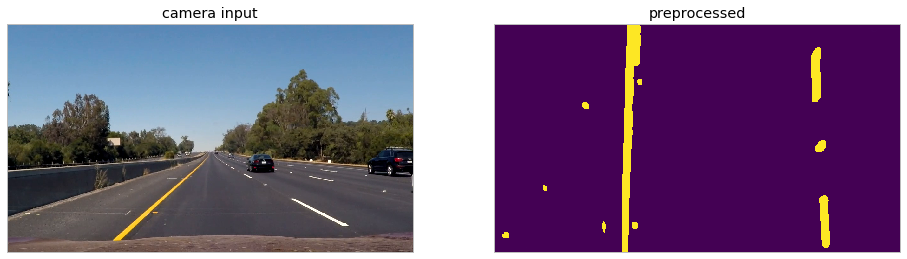

In [21]:
show = laneFindingPipeline.utils.show
fig, (left, right) = plt.subplots(ncols=2, figsize=(16, 6));
show(frame, ax=left, title='camera input');
show(pipeline(frame), ax=right, title='preprocessed');

The goal now is to fit two polynomials to this data, and extract from these curves some geometric information which would presumably be useful for control tasks such as lane-keeping.

In [22]:
laneFinder = laneFindingPipeline.LaneFinder(colorFilter=pipeline)

In [23]:
laneFinder.process(
    allFrames['project'][:32], 'doc/images/project_results.gif', tqdmKw=dict(pbar=False), 
    showCentroids=False, 
)

## Assigning pixels to the right and left markings

It was suggested to use some combination of three possible methods to find a subset of pixels on which to regress our lane-defining polynomials. We choose from:
1. For each horizontal slice of the image, sum over rows, then look for peaks in the resulting signal. Stitch these peaks together across slices to get a set of horizontal box centers. For boxes of a given width, take all the pixels within identified by the preprocessing filter.
2. Similar, but with convolutions. I chose to use a gaussian kernel. For a given horizontal slice of the preprocessed image, we sum over rows, and then, instead of explicitly searching for peaks, we search for the peak in the convolution of this signal with a chosen filter. This method is slightly more robust to noise.
3. Given a previously fitted polynomial, search in a fixed margin to the left and right for pixels identified by the preprocessor. Of the three, this method most imposes the strongest assumption that the shape of the lane lines will not change drastically from frame to frame.

The convolutional pixel finder begins by establishing a kernel (`window`) to be swept over the image, and determining the locations of nonzero pixels in the input. We use `initialGuessMarking` to generate naive starting guesses in for x-locations of the curves, in the centers of the left and right sides of the image.

In [24]:
convolutionalMarkingFinder = laneFindingPipeline.ConvolutionalMarkingFinder()
src(convolutionalMarkingFinder.update, end=38)

We then iterate over a small number of horizontal slices of the images (`levels`). In each, we
1. Sum over rows in the slice to create a 1D row-averaged signal.
2. If there are any nonzero convolution values in a restricted search window around the previous center (or initial guess), choose the new center to be at the maximum (else, leave the center unchanged).
3. Accumulate from each level the pixels inside the optimal convolution window.

In step 2, if no convolution pixels are nonzero, I previously tried using a linear extrapolation of the centers of the last two levels (if available). This is helpful, for instance, when there are large gaps in the broken white line. However, this sometimes backfires when a blob of pixels beside the marking pushes the window to the left and is followed by such a gap, which then produces a strongly wrong linear-projection guess for the next-level center.

In [25]:
src(convolutionalMarkingFinder.update, start=38, end=91)

Finally, we use the found indices to extract the actually pixel locations, and use these to regress two `LaneMarking` objects, and save the found centers for plotting purposes.

In [26]:
src(convolutionalMarkingFinder.update, start=91)

At the moment, this is followed up by a set of quality checks used to decide whether these markings should be kept, or replaced with default guesses. If the checks fail (return `False`), they reset the last-guess storge (`self.__getitem__`). We then repeat the update with the new new (default) guesses. A better use for this check is dicussed in the conclusion section below.

In [27]:
src(laneFindingPipeline.MarkingFinder.postUpdateQualityCheck)

The checks themselves consist of
1. ensuring that sufficiently many nonzero pixels were actually found,
2. ensuring that the two radii of curvature aren't drastically different, and
3. ensuring that the two fits haven't collappsed into the same curve.

Additionally, I generate an overall quality score, but this is poorly tuned of dubious use.

In [28]:
src(laneFindingPipeline.MarkingFinder.evaluateFitQuality)

## Fitting `LaneMarking` objects
The `LaneMarking` object holds polynomial fits to provided (y,x) data, and calculates radius of curvature on demand. At the moment, I simply use the same regression method on data with transformed units to produce `worldFit` in addition to `fit`. Really, this should be analytically computed.

In [29]:
src(laneFindingPipeline.LaneMarking.__init__)

I also allow for calculating the radius of curvature of these lane markings by leveraging the `np.polyder` method, evaluating at the point nearest the camera. So, technically, we're preprepared for any order of fitted polynomial, though I suspect that anything over cubic wouldn't help anything.

In [30]:
propertySrc(laneFindingPipeline.LaneMarking(), 'radius')

I do include a Scikit-Learn RANSAC regressor as an option, but do not use it since it requires some tuning which I don't have time to do now (but see the conclusion section below).

In [31]:
src(laneFindingPipeline.LaneMarking.regressPoly)

## Meters per pixel
To determine the correct right y and x meters/pixel conversions, I took a well-behaved frame from the main project video, measured the relevant distances, and compared these to the [California lane marking spacing standards](http://www.dot.ca.gov/trafficops/camutcd/camutcd2014rev2.html). These say that these white broken highway markings should be 12 feet long (with a small dot centered in the 36-foot gap between markings), and that lanes are generally [12 feet wide](http://www.dot.ca.gov/hq/paffairs/faq/faq92.htm).

For good measure, I also determined the width in pixels of a typical 80-inch car, and displayed a little car decal on the inset image in the main output video.

<img src="doc/images/metersPerPixel.png" />

# Smoothing fits over time
To hedge against sharp changes in the fit which aren't rejected by the quality checks above, we use a simple box filter to average fits over time for use in the actual plotting. This is implemented in terms of a general smoothing window, to allow for future use with the `WeightedSmoother` class, if I can devise a reasonable way to give fits continuously-valued quality scores.

In [32]:
import smoothing

In [33]:
src(smoothing.Smoother, end=-4)

In [34]:
src(smoothing.WindowSmoother)

In [35]:
src(smoothing.BoxSmoother)

# Final result

For each frame, we use the preprocessing pipeline created with `cvflow` to undistort, perspective-transform, and threshold images. We then use code in `LaneFinder` to create some `LaneMarking` objects.

Finally, we use `LaneFinder.draw` to found lane fill, convolutional search windows, etc. first onto a small inset figure, then (afer calling `perspectiveTransformer(inset, inv=True)` to perform the inverse transformation for painting over the main video with `cv2.addWeighted`.

Below, we'll run this complete pipeline on each of the provided test videos.

In [36]:
vids = {}

In [37]:
# for key in 'project', 'challenge', 'harder_challenge':
#     vid = laneFinder.process(
#         allFrames[key], 'doc/images/%s_full_results.mp4' % key,
#         showCentroids=False,
#     );
#     vids[key] = vid

I've uploaded these results to youtube for the [main project video](https://youtu.be/uWz20JKjtK4), [challenge](https://youtu.be/xy4LS7Wrc1s), and the [harder challenge](https://youtu.be/yssBi3Vf978).

# Conclusion

The divide-and-conquer approach of the `FullPipeline` is strongly reminiscent of the internal feature-finding strategy of convolutional neural networks (CNNs). For this reason, as well as the extensive per-node tweaking requied to get results out of this method, it's clear that an alternate CNN attempt is warranted.

While results are respectable, there is clear room for improvment, and I can list a few ways in which I might attempt this when I return later.

It would be good to use a hierarchy of pixel-finding strategies. Since this sort of logic was more of the topic of the earlier Hough-transform based assignment, I chose to spend more time on the computer vision aspect of this project. 

For simplicity, I simply used the convolutional approach for every frame here. However, using the margin approach (implemented separately in `MarginSearchMarkingFinder`) might both slightly improve speed but also greatly improve stability. Especially e.g. in cases where the broken-white right lane begins with a gap near the camera, using the convolutional approach is prone to sudden jumps in the location of window center in the first layer. (This is especially true of the lower half of the preprocessed images, which tend to contain more noise by virtue of the greater detail of their before-perspective preimages.) The margin-search approach is not prone to this problem. I believe that using the margin-search method in most cases (and reverting to the convolutional method only when a quality metric like number-of-points dips below threshold) would likely fix the remaining small issues in the main project video.

Additionally, it would be good to continue this change-strategy-on-failure technique by simply skipping frames for which the convolutional method also "failed" (per some quality metric). These lane marking fits just would not get integrated into the smoothing.

In this line, it would also be useful to improve the quality metric. I'm fond of the idea of not throwing out low-quality (but not outright wrong) fits completely, using the `WeightedSmoother` that is implemented alongside the currently-used `BoxSmoother`. It seems intuitive that mean squared error should be included here, but this could be misleading if the number of points found was low (making MSE artificially high). So, some sort of combination is needed.

MSE itself would be defined differently if I used RANSAC instead of normal least-squares `np.polyfit` to find the fitting coefficients--probably I'd need to use MSE within the inliers group defined in RANSAC. Using RANSAC would help greatly, as I'd be able to be less careful with my restrictive masks in the initial OpenCV preprocessing. RANSAC would be able to leave out the many outliers, picking up on the underlying narrow band of dense points.

I would also like to try a predictive model for the evolution of the lane lines. For example, I coul duse a polynomial fit in time of each coefficient, or even just linearly project the last two fit vectors. However, I believe this is to be the topic of a future project, so I'll hold off for now.

Finally, there is a completely different category of error that occurs sometimes in the `harder_challenge_video.mp4` file, where bright sunlight causes reflections of the car dashboard to appear in the windshield. Though not shown here, I did make a small attempt to use (a lack of) optical flow to detect these pixels (see the `DenseOpticalFlow`, `SimplisticOpticalFlow` and `RunningAverage` operations implemented in workers.py). This didn't work, but I belive the intuition is good: temporarily exclude from the preprocessing portions of the video that remain unchanged for several frames.
